In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import time
import os
from os import listdir
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import manifold, decomposition
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve
from sklearn import cluster, metrics
from glob import glob

import mlflow
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout 
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, Input
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.optimizers import RMSprop 
import matplotlib.image as mpimg
from tensorflow.keras.optimizers import Adam
from keras_tuner import RandomSearch
from tensorflow.keras.optimizers import SGD

## importation des images

In [48]:
# Définir le chemin vers les données
path = './Data/images/'
# Charger et prétraiter les images

list_labels = ["boxer", "Chihuahua", "Eskimo_dog"]
label_no_name = "no_name"

def photo_class(photo) :
    for label in list_labels :
        if label in photo : 
            return label
    return label_no_name
    
data_path = glob(path+'**/*.jp*', recursive=True)

def data_fct(path) :
    list_photos = [file for file in path]
    print(len(list_photos))
    data = pd.DataFrame()
    data["image_path"] = list_photos
    data["label_name"] = data["image_path"].apply(lambda x : photo_class(x))
    return data

data = data_fct(data_path)
data, data_test = train_test_split(data, test_size=0.2, random_state=42)
le = preprocessing.LabelEncoder()
le.fit(data["label_name"])
data["label"] = le.transform(data["label_name"])
data = data.reset_index(drop=True)
data_test["label"] = le.transform(data_test["label_name"])
data_test = data_test.reset_index(drop=True)
display(data)
data_test.head(5)


453


,image_path,label_name,label
0,./Data/images/Chihuahua/n02085620_12334.jpg,Chihuahua,0
1,./Data/images/Chihuahua/n02085620_3928.jpg,Chihuahua,0
2,./Data/images/Chihuahua/n02085620_11258.jpg,Chihuahua,0
3,./Data/images/boxer/n02108089_1104.jpg,boxer,2
4,./Data/images/boxer/n02108089_9778.jpg,boxer,2
...,...,...,...
357,./Data/images/Chihuahua/n02085620_2903.jpg,Chihuahua,0
358,./Data/images/Eskimo_dog/n02109961_1032.jpg,Eskimo_dog,1
359,./Data/images/boxer/n02108089_125.jpg,boxer,2
360,./Data/images/boxer/n02108089_3899.jpg,boxer,2


,image_path,label_name,label
0,./Data/images/boxer/n02108089_2653.jpg,boxer,2
1,./Data/images/Chihuahua/n02085620_10976.jpg,Chihuahua,0
2,./Data/images/boxer/n02108089_485.jpg,boxer,2
3,./Data/images/boxer/n02108089_3028.jpg,boxer,2
4,./Data/images/Eskimo_dog/n02109961_16095.jpg,Eskimo_dog,1


In [3]:
print(data.groupby("label").count())
print(data_test.groupby("label").count())

       image_path  label_name
label                        
0             118         118
1             126         126
2             118         118
       image_path  label_name
label                        
0              34          34
1              24          24
2              33          33


## functions

In [65]:
def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)
    
    corresp = np.argmax(conf_mat, axis=0)
    print ("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

def create_model_fct_vanilla():
    my_model = Sequential([
        Input(shape=(224, 224, 3)),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(3, activation='softmax')
        ])

    #display(my_model.summary())
    return my_model

def build_model(hp):
    model = Sequential([
        Input(shape=(224, 224, 3)),
        Conv2D(hp.Int('conv_1_filters', min_value=32, max_value=64, step=32), (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(hp.Int('conv_2_filters', min_value=64, max_value=128, step=64), (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(hp.Int('conv_3_filters', min_value=128, max_value=256, step=128), (3, 3), activation='relu'),
        GlobalAveragePooling2D(),
        Dense(hp.Int('dense_units', min_value=32, max_value=128, step=32), activation='relu'),
        Dropout(hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)),
        Dense(3, activation='softmax')
    ])
    
    # Choose optimizer
    optimizer_choice = hp.Choice('optimizer', values=['adam', 'sgd', 'rmsprop'])
    
    # Set learning rate
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    
    if optimizer_choice == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_choice == 'sgd':
        optimizer = SGD(learning_rate=learning_rate)
    else:  # 'rmsprop'
        optimizer = RMSprop(learning_rate=learning_rate)
    
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

'''def image_prep_fct(data) :
    prepared_images = []
    for image_num in range(len(data['image_path'])) :
        img = (load_img(
            data['image_path'][image_num],
            target_size=(224, 224)))
        img = img_to_array(img)
        img = img.reshape((img.shape[0], img.shape[1], img.shape[2]))
        img = preprocess_input(img)
        prepared_images.append(img)
        prepared_images_np = np.array(prepared_images)
    return prepared_images_np'''

def image_prep_fct(data):
    prepared_images = []
    for image_num in range(len(data['image_path'])):
        # Load and resize the image
        img = load_img(data['image_path'][image_num], target_size=(224, 224))
        # Convert the image to a numpy array
        img = img_to_array(img)
        # Normalize the image to the range [0, 1]
        img = img / 255.0
        # Centering around zero
        img = img - 0.5
        img = img * 2.0
    
        # Whitening
        mean = np.mean(img, axis=(0, 1, 2), keepdims=True)
        std = np.std(img, axis=(0, 1, 2), keepdims=True)
        img = (img - mean) / (std + 1e-7)  # Add a small value to avoid division by zero
    
        # Equalization (histogram equalization)
        img = tf.image.per_image_standardization(img)  # This operation normalizes each image individually
        # Append the processed image to the list
        prepared_images.append(img)
    # Convert the list of images to a numpy array
    prepared_images_np = np.array(prepared_images)
    return prepared_images_np

import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf

def custom_preprocess(img):
    # Check if img is already a numpy array; if not, convert it
    if not isinstance(img, np.ndarray):
        raise ValueError("Input must be a numpy array")

    # Normalize the image to the range [-1, 1]
    img = (img / 255.0) * 2.0 - 1.0
    
    # Whitening: Mean subtraction and division by standard deviation
    mean = np.mean(img, axis=(0, 1, 2), keepdims=True)
    std = np.std(img, axis=(0, 1, 2), keepdims=True)
    img = (img - mean) / (std + 1e-7)  # Add a small value to avoid division by zero
    
    # Optionally, apply histogram equalization
    img = tf.image.per_image_standardization(img)
    
    return img

def data_flow_fct(data, datagen, data_type=None):
    data_flow = datagen.flow_from_dataframe(
        dataframe=data,            # Pass the dataframe containing the data
        directory='',              # Directory is set to '' as paths are in dataframe
        x_col='image_path',        # Column in dataframe with image paths
        y_col='label_name',        # Column in dataframe with labels
        target_size=(224, 224),    # Target size for resizing images
        class_mode='categorical',  # Use 'categorical' for multi-class classification
        batch_size=batch_size,     # Batch size for the data flow
        shuffle=True,              # Shuffle the data
        seed=42,                   # Seed for reproducibility
        subset=data_type           # Pass 'training' or 'validation' to subset
    )
    return data_flow

# classification avec modele sans entrainement prealable

In [5]:
images_np = image_prep_fct(data)
print(images_np.shape)
images_np_test = image_prep_fct(data_test)
print(images_np_test.shape)

batch_size = 32

(362, 224, 224, 3)
(91, 224, 224, 3)


In [6]:
X = images_np
y = to_categorical(data['label'])

X_test = images_np_test
y_test = to_categorical(data_test['label'])

y

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.]])

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)
X_train.shape

(271, 224, 224, 3)

### tuning without DA

In [15]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='tuner_results_vanilla',
    project_name='my_model_without_DA'
)

batch_size = 32  # Example batch size

# Create an instance of ImageDataGenerator without data augmentation
datagen = ImageDataGenerator()

# Adjust the generators to automatically handle the end of the dataset
train_generator = datagen.flow(X_train, y_train, batch_size=batch_size, shuffle=True)
val_generator = datagen.flow(X_val, y_val, batch_size=batch_size, shuffle=False)

# Remove manual calculation of steps per epoch
tuner.search(
    train_generator,
    epochs=10,  # Adjust the number of epochs according to your needs
    validation_data=val_generator
)

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
# Retrieve the best model
best_model = tuner.get_best_models(num_models=1)[0]

Trial 10 Complete [00h 03m 12s]
val_accuracy: 0.5384615659713745

Best val_accuracy So Far: 0.593406617641449
Total elapsed time: 00h 29m 55s


/opt/anaconda3/envs/realboap6/lib/python3.9/site-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [16]:
print("Best hyperparameters found:")
print(best_hps.values)

# Get a summary of the tuning process
tuner.results_summary()

# Optionally, save the results to a file
results = tuner.oracle.get_best_trials(num_trials=10)
results_data = [{'trial_id': t.trial_id, 'score': t.score, **t.hyperparameters.values} for t in results]

# Convert to DataFrame for easier manipulation and saving
results_df = pd.DataFrame(results_data)

# Save to CSV
results_df.to_csv('tuning_results_my_model_without_DA.csv', index=False)

Best hyperparameters found:
{'conv_1_filters': 64, 'conv_2_filters': 64, 'conv_3_filters': 256, 'dense_units': 32, 'dropout': 0.4, 'optimizer': 'rmsprop', 'learning_rate': 0.0004010402068654687}
Results summary
Results in tuner_results_vanilla/my_model_without_DA
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 00 summary
Hyperparameters:
conv_1_filters: 64
conv_2_filters: 64
conv_3_filters: 256
dense_units: 32
dropout: 0.4
optimizer: rmsprop
learning_rate: 0.0004010402068654687
Score: 0.593406617641449

Trial 03 summary
Hyperparameters:
conv_1_filters: 64
conv_2_filters: 128
conv_3_filters: 128
dense_units: 32
dropout: 0.0
optimizer: rmsprop
learning_rate: 0.0009486748327517953
Score: 0.593406617641449

Trial 01 summary
Hyperparameters:
conv_1_filters: 32
conv_2_filters: 128
conv_3_filters: 256
dense_units: 64
dropout: 0.0
optimizer: rmsprop
learning_rate: 0.0027494740914787118
Score: 0.5714285969734192

Trial 06 summary
Hyperparameters:
conv_1_filters: 64

In [22]:
# Création du modèle
with tf.device('/gpu:0'): 
    model1 = create_model_fct_vanilla()

# Specify your desired learning rate
learning_rate = 0.0004
    
optimizer = RMSprop(learning_rate=learning_rate)
# Compile the model with the new optimizer
model1.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    
# Création du callback
model1_save_path1 = "./my_model_without_DA.keras"
checkpoint = ModelCheckpoint(model1_save_path1, monitor='val_loss', verbose=1, save_best_only=True, mode='min', save_weights_only=False)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

In [23]:
# Entraîner sur les données d'entraînement (X_train, y_train)
with tf.device('/gpu:0'): 
    history1 = model1.fit(X_train, y_train, epochs=50, batch_size=32, 
                       callbacks=callbacks_list, validation_data=(X_val, y_val), verbose=1)

Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3619 - loss: 1.1309
Epoch 1: val_loss improved from inf to 1.06960, saving model to ./my_model_without_DA.keras
9/9 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.3622 - loss: 1.1297 - val_accuracy: 0.4286 - val_loss: 1.0696
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4388 - loss: 1.0793
Epoch 2: val_loss did not improve from 1.06960
9/9 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.4367 - loss: 1.0795 - val_accuracy: 0.3736 - val_loss: 1.0736
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3545 - loss: 1.0767
Epoch 3: val_loss improved from 1.06960 to 1.04367, saving model to ./my_model_without_DA.keras
9/9 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.3574 - loss: 1.0765 - val_accuracy: 0.4066 - val_loss: 1.0437
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4516 - loss: 1.0620
Epoch 4: val_loss improved from 1.04367 to 1.00913, saving model to ./my_model_without_DA.keras
9/9 ━━

In [24]:
# Score du dernier epoch

loss, accuracy = model1.evaluate(X_train, y_train, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
print("Training Loss    : {:.4f}".format(loss))
print()
loss, accuracy = model1.evaluate(X_val, y_val, verbose=True)
print("Validation Accuracy:  {:.4f}".format(accuracy))
print("Validation Loss    : {:.4f}".format(loss))

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 363ms/step - accuracy: 0.5535 - loss: 0.9532
Training Accuracy: 0.5720
Training Loss    : 0.9540

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 423ms/step - accuracy: 0.5529 - loss: 0.9334
Validation Accuracy:  0.5824
Validation Loss    : 0.9265


In [25]:
# Score de l'epoch optimal

model1.load_weights(model1_save_path1)

loss, accuracy = model1.evaluate(X_val, y_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))
print("Validation Loss     :  {:.4f}".format(loss))

loss, accuracy = model1.evaluate(X_test, y_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))
print("Test Loss           :  {:.4f}".format(loss))


Validation Accuracy :  0.5934
Validation Loss     :  0.9227
Test Accuracy       :  0.5055
Test Loss           :  0.9655


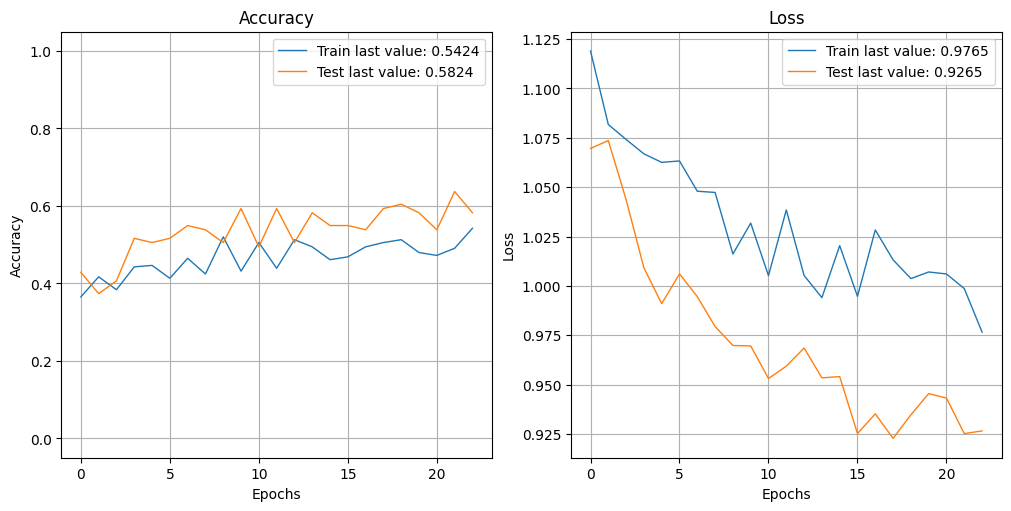

In [26]:
show_history(history1)
plot_history(history1, path="standard.png")
plt.close()

In [27]:
y_val_num = np.argmax(y_val, axis=1)
y_val_pred = np.argmax(model1.predict(X_val), axis=1)
print(y_val_num)
print()
print(y_val_pred)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 345ms/step
[2 2 0 1 1 1 0 0 1 1 0 0 0 0 1 2 1 2 0 1 2 0 2 0 0 0 0 0 1 2 0 1 2 0 0 2 2
 2 0 1 1 1 0 2 0 1 1 2 2 0 0 2 1 0 2 2 2 0 2 2 2 0 1 1 2 1 2 2 1 0 2 1 2 2
 1 0 2 1 1 0 1 1 1 1 2 1 1 1 2 0 1]

[1 2 2 1 1 1 2 2 1 1 1 2 0 1 1 0 1 1 2 1 1 2 0 1 2 0 2 0 2 2 0 1 2 2 1 2 2
 1 2 1 1 1 0 2 0 2 1 2 2 2 2 2 1 0 1 2 1 1 2 0 2 1 1 1 2 0 1 2 1 2 0 1 1 2
 1 0 2 1 1 1 1 1 1 1 2 1 1 1 2 1 2]


In [28]:
conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred)
print(conf_mat)

[[ 8  8 13]
 [ 1 28  3]
 [ 4  8 18]]


In [29]:
y_val_pred_transform = conf_mat_transform(y_val_num, y_val_pred)
conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred_transform)
print(conf_mat)
print()
print(metrics.classification_report(y_val_num, y_val_pred_transform))

Correspondance des clusters :  [0 1 2]
[[ 8  8 13]
 [ 1 28  3]
 [ 4  8 18]]

              precision    recall  f1-score   support

           0       0.62      0.28      0.38        29
           1       0.64      0.88      0.74        32
           2       0.53      0.60      0.56        30

    accuracy                           0.59        91
   macro avg       0.59      0.58      0.56        91
weighted avg       0.59      0.59      0.57        91



<Axes: >

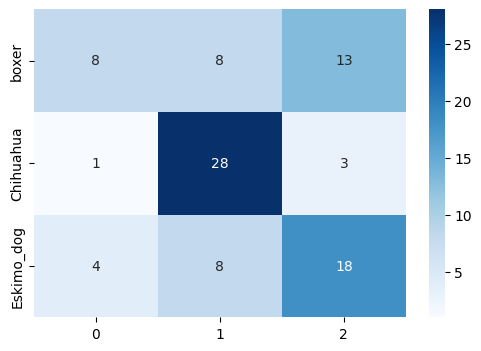

In [30]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in list_labels],
                  columns = [i for i in "012"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")

# modele non pre entrainé avec data augmentation

In [56]:
# Pour mélanger les images, classées initalement par classe
data = data.sample(frac=1, random_state=42).reset_index(drop=True)


In [99]:
def data_flow_fct(data, datagen, data_type=None, shuffle=None):
    data_flow = datagen.flow_from_dataframe(
        dataframe=data,            # Pass the dataframe containing the data
        directory='',              # Directory is set to '' as paths are in dataframe
        x_col='image_path',        # Column in dataframe with image paths
        y_col='label_name',        # Column in dataframe with labels
        target_size=(224, 224),    # Target size for resizing images
        class_mode='categorical',  # Use 'categorical' for multi-class classification
        batch_size=batch_size,     # Batch size for the data flow
        shuffle=shuffle,              # Shuffle the data
        seed=42,                   # Seed for reproducibility
        subset=data_type           # Pass 'training' or 'validation' to subset
    )
    return data_flow

In [105]:
# Define batch size
batch_size = 32  # Adjust this value as needed

# Create an instance of ImageDataGenerator with augmentation for training
datagen_train = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.25,  # Split 25% of the data for validation
    preprocessing_function=custom_preprocess
)

# Create training and validation data flows
train_flow = data_flow_fct(data, datagen_train, data_type='training', shuffle=True)
val_flow = data_flow_fct(data, datagen_train, data_type='validation', shuffle=True)

# Create an instance of ImageDataGenerator without augmentation for testing
datagen_test = ImageDataGenerator(
    preprocessing_function=custom_preprocess
)

# Create test data flow
test_flow = data_flow_fct(data_test, datagen_test, data_type=None, shuffle=False)

Found 272 validated image filenames belonging to 3 classes.
Found 90 validated image filenames belonging to 3 classes.
Found 91 validated image filenames belonging to 3 classes.


In [61]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='tuner_results_vanilla',
    project_name='my_model_tuning_with_DA',
)

# Start the hyperparameter search
tuner.search(
    train_flow,
    epochs=10,  # Adjust the number of epochs according to your needs
    validation_data=val_flow
)

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
# Retrieve the best model
best_model = tuner.get_best_models(num_models=1)[0]

Trial 10 Complete [00h 04m 58s]
val_accuracy: 0.5111111402511597

Best val_accuracy So Far: 0.5777778029441833
Total elapsed time: 00h 32m 39s


/opt/anaconda3/envs/realboap6/lib/python3.9/site-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [62]:
print("Best hyperparameters found:")
print(best_hps.values)

# Get a summary of the tuning process
tuner.results_summary()

# Optionally, save the results to a file
results = tuner.oracle.get_best_trials(num_trials=10)
results_data = [{'trial_id': t.trial_id, 'score': t.score, **t.hyperparameters.values} for t in results]

# Convert to DataFrame for easier manipulation and saving
import pandas as pd
results_df = pd.DataFrame(results_data)

# Save to CSV
results_df.to_csv('tuning_results_vanilla_with_DA.csv', index=False)

Best hyperparameters found:
{'conv_1_filters': 32, 'conv_2_filters': 64, 'conv_3_filters': 128, 'dense_units': 128, 'dropout': 0.30000000000000004, 'optimizer': 'rmsprop', 'learning_rate': 0.002728096254233701}
Results summary
Results in tuner_results_vanilla/my_model_tuning_with_DA
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 02 summary
Hyperparameters:
conv_1_filters: 32
conv_2_filters: 64
conv_3_filters: 128
dense_units: 128
dropout: 0.30000000000000004
optimizer: rmsprop
learning_rate: 0.002728096254233701
Score: 0.5777778029441833

Trial 07 summary
Hyperparameters:
conv_1_filters: 32
conv_2_filters: 64
conv_3_filters: 128
dense_units: 32
dropout: 0.1
optimizer: adam
learning_rate: 0.0014796448394755802
Score: 0.5666666626930237

Trial 09 summary
Hyperparameters:
conv_1_filters: 64
conv_2_filters: 64
conv_3_filters: 256
dense_units: 128
dropout: 0.4
optimizer: adam
learning_rate: 0.0005162885734768005
Score: 0.5111111402511597

Trial 01 summary
Hype

In [68]:
# Specify your desired learning rate
learning_rate = 0.002

# Création du modèle
with tf.device('/gpu:0'): 
    my_model = create_model_fct_vanilla()

    #optimizer = RMSprop(learning_rate=learning_rate)
    optimizer = RMSprop(learning_rate=learning_rate)
    # Compile the model with the new optimizer
    my_model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

# Création du callback
my_model_save_path = "./my_model_with_DA.keras"
checkpoint = ModelCheckpoint(my_model_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min', save_weights_only=False)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

In [69]:
with tf.device('/gpu:0'): 
    history2 = my_model.fit(train_flow,
                    validation_data=val_flow,
                    epochs=50, callbacks=callbacks_list, verbose=1)
my_model.summary()

Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3740 - loss: 1.1240
Epoch 1: val_loss improved from inf to 1.07543, saving model to ./my_model_with_DA.keras
9/9 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.3737 - loss: 1.1228 - val_accuracy: 0.3889 - val_loss: 1.0754
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3971 - loss: 1.0844
Epoch 2: val_loss improved from 1.07543 to 1.05022, saving model to ./my_model_with_DA.keras
9/9 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.4001 - loss: 1.0839 - val_accuracy: 0.3889 - val_loss: 1.0502
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4480 - loss: 1.0732
Epoch 3: val_loss did not improve from 1.05022
9/9 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.4524 - loss: 1.0697 - val_accuracy: 0.3889 - val_loss: 1.0586
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4834 - loss: 1.0424
Epoch 4: val_loss did not improve from 1.05022
9/9 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.4818 - los

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 220,296 (860.54 KB)

 Trainable params: 110,147 (430.26 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 110,149 (430.27 KB)

In [70]:
# Score du dernier epoch

loss, accuracy = my_model.evaluate(train_flow, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = my_model.evaluate(val_flow, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 331ms/step - accuracy: 0.5740 - loss: 0.9185
Training Accuracy   : 0.5699

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 369ms/step - accuracy: 0.4632 - loss: 0.9588
Validation Accuracy :  0.4889


In [101]:
import keras
# Score de l'epoch optimal
my_model = keras.models.load_model('./my_model_with_DA.keras')

loss, accuracy = my_model.evaluate(val_flow, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))
loss, accuracy = my_model.evaluate(test_flow, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))

/opt/anaconda3/envs/realboap6/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Validation Accuracy :  0.5111
Test Accuracy       :  0.5385


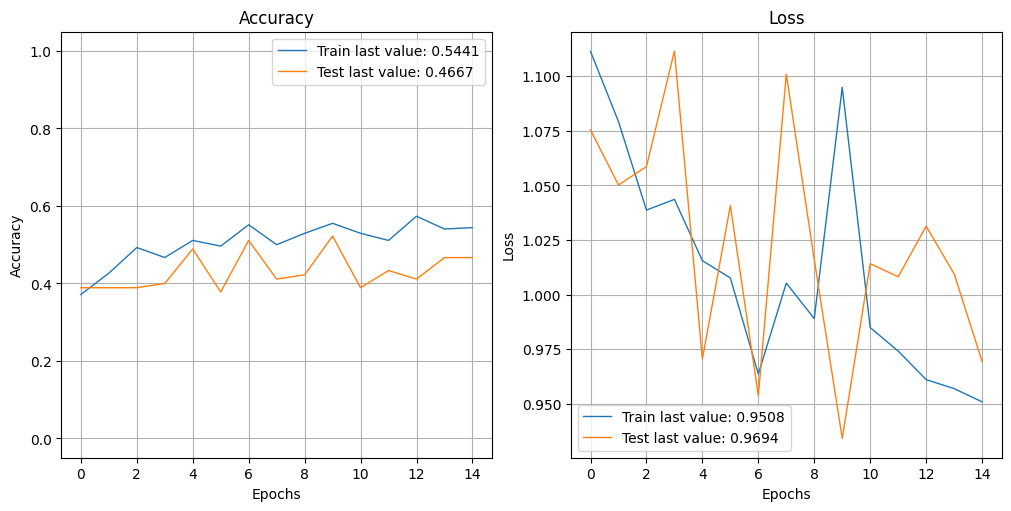

In [73]:
show_history(history2)
plot_history(history2, path="standard.png")
plt.close()

In [76]:
print(test_flow.classes)

[2, 0, 2, 2, 1, 1, 1, 0, 2, 0, 0, 2, 0, 2, 2, 0, 1, 2, 1, 0, 0, 0, 1, 0, 2, 2, 0, 2, 0, 2, 2, 1, 2, 0, 2, 0, 2, 2, 0, 0, 1, 0, 2, 0, 1, 0, 0, 1, 2, 1, 2, 0, 1, 2, 2, 1, 0, 2, 0, 2, 1, 0, 0, 1, 1, 0, 2, 1, 1, 1, 1, 2, 0, 1, 2, 1, 0, 2, 2, 0, 1, 2, 2, 0, 0, 2, 2, 0, 0, 0, 1]


In [106]:
y_val_num = test_flow.classes
y_val_pred = np.argmax(my_model.predict(test_flow), axis=1)
print(y_val_num)
print()
print(y_val_pred)


/opt/anaconda3/envs/realboap6/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step
[2, 0, 2, 2, 1, 1, 1, 0, 2, 0, 0, 2, 0, 2, 2, 0, 1, 2, 1, 0, 0, 0, 1, 0, 2, 2, 0, 2, 0, 2, 2, 1, 2, 0, 2, 0, 2, 2, 0, 0, 1, 0, 2, 0, 1, 0, 0, 1, 2, 1, 2, 0, 1, 2, 2, 1, 0, 2, 0, 2, 1, 0, 0, 1, 1, 0, 2, 1, 1, 1, 1, 2, 0, 1, 2, 1, 0, 2, 2, 0, 1, 2, 2, 0, 0, 2, 2, 0, 0, 0, 1]

[2 0 2 1 1 2 2 2 0 2 0 2 0 1 2 2 2 0 1 2 2 0 1 0 2 1 2 2 1 2 2 1 2 0 2 2 0
 2 1 2 2 2 2 2 1 0 2 1 2 1 2 1 1 1 2 1 0 2 2 1 1 1 0 1 1 2 1 2 1 1 2 1 2 2
 2 2 0 1 2 0 1 2 2 2 1 1 0 0 0 0 2]


In [107]:
y_val_pred_transform = conf_mat_transform(y_val_num, y_val_pred)
conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred_transform)
print(conf_mat)
print()
print(metrics.classification_report(y_val_num, y_val_pred_transform, zero_division=0))

Correspondance des clusters :  [0 1 2]
[[14  5 15]
 [ 0 15  9]
 [ 4  9 20]]

              precision    recall  f1-score   support

           0       0.78      0.41      0.54        34
           1       0.52      0.62      0.57        24
           2       0.45      0.61      0.52        33

    accuracy                           0.54        91
   macro avg       0.58      0.55      0.54        91
weighted avg       0.59      0.54      0.54        91



<Axes: >

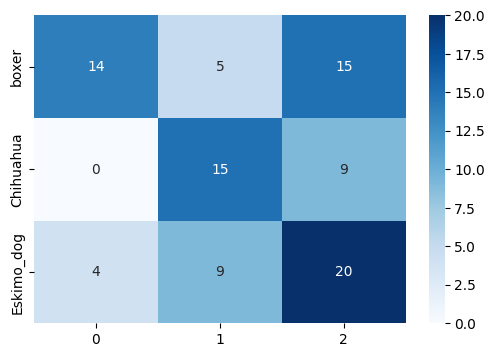

In [104]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in list_labels],
                  columns = [i for i in "012"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")